# Setup

In [ ]:
!pip install -U pymfe

In [ ]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
%config InlineBackend.figure_format = 'retina'

In [ ]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 25
BATCH_IMAGE_INDEX = 0
SIZE_LOOP_TO_HOOK = 1


IMG_SIZE = 32
N_CLASSES = 10

# Funções auxiliares

In [ ]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax.legend()
    fig.show()

    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
# intermediateRepresentationsMapTensor = {}

def get_accuracy_with_hooks(model, data_loader, intermediateRepresentationsMapTensor, ty, device,hook_layers=True):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0
    # tys = []
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)
            ty = torch.cat((ty,y_true[BATCH_IMAGE_INDEX].reshape(1)),0)
            # tys.append(y_true[0])

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)
            if hook_layers:
              for _, (layerName, layer) in enumerate(model.named_children()):
                # print(activation[layerName].size())
                # print(activation[layerName][0].size())
                if layerName in intermediateRepresentationsMapTensor:
                  t = intermediateRepresentationsMapTensor[layerName]
                  # t = torch.cat((t,activation[layerName]),0)
                  t = torch.cat((t,torch.unsqueeze(activation[layerName][BATCH_IMAGE_INDEX],0)),0)
                  # print(t.size())
                  intermediateRepresentationsMapTensor[layerName] = t
                else:
                  intermediateRepresentationsMapTensor[layerName] = torch.unsqueeze(activation[layerName][BATCH_IMAGE_INDEX],0)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()


    return (correct_pred.float() / n, ty)

def training_loop_with_hooks(model, criterion, optimizer, train_loader, valid_loader, epochs, device, hook_every=1,hook_layers=True):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracy = pd.DataFrame(columns=['epoch','value'])
    valid_accuracy = pd.DataFrame(columns=['epoch','value'])

    testCompTable = pd.DataFrame(columns=['epoch','layer','metric','value'])
    trainCompTable = pd.DataFrame(columns=['epoch','layer','metric','value'])


    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if (epoch % hook_every == (hook_every - 1)):

            if(hook_layers):
              hooks = attach_hooks(model)
            ty = torch.Tensor().to(DEVICE)
            intermediateRepresentationsMapTensor = {}
            train_acc, ty = get_accuracy_with_hooks(model, train_loader, intermediateRepresentationsMapTensor, ty, device=device,hook_layers=hook_layers)
            # print(ty)
            # print(intermediateRepresentationsMapTensor)
            entry = {"epoch": epoch, "value": train_acc.to('cpu').numpy()}
            entryDf = pd.DataFrame(entry, index=[0])
            train_accuracy = pd.concat([train_accuracy,entryDf],ignore_index=True)
            trainCompTable = complexity_calculator(trainCompTable,intermediateRepresentationsMapTensor,ty,epoch)


            ty = torch.Tensor().to(DEVICE)
            intermediateRepresentationsMapTensor = {}
            valid_acc, ty = get_accuracy_with_hooks(model, valid_loader, intermediateRepresentationsMapTensor, ty, device=device,hook_layers=hook_layers)
            entry = {"epoch": epoch, "value": valid_acc.to('cpu').numpy()}
            entryDf = pd.DataFrame(entry, index=[0])
            valid_accuracy = pd.concat([valid_accuracy,entryDf],ignore_index=True)
            testCompTable = complexity_calculator(testCompTable,intermediateRepresentationsMapTensor,ty,epoch)

            if(hook_layers):
              remove_hooks(hooks)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses), (trainCompTable,testCompTable), (train_accuracy, valid_accuracy)

activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def attach_hooks(model):
  hooks = []
  for idx, (layerName, layer) in enumerate(model.named_children()):
    hooks.append(layer.register_forward_hook(getActivation(layerName)))
  return hooks

def remove_hooks(hooks):
  for h in hooks:
    h.remove()

def complexity_calculator(DataMap,intermediateRepresentationsMapTensor,ty,epoch):
  for layerName in intermediateRepresentationsMapTensor.keys():
    intermediateRepresentationsTensor = intermediateRepresentationsMapTensor[layerName]
    complexitiesMap = complexity_calculator_layer(intermediateRepresentationsTensor,ty)
    for complexityMetric in complexitiesMap.keys():
      entry = {"epoch": epoch, "layer": layerName, "metric": complexityMetric, "value": complexitiesMap[complexityMetric]}
      entryDf = pd.DataFrame(entry, index=[0])
      # DataMap.append(entry,ignore_index=True)
      DataMap = pd.concat([DataMap,entryDf],ignore_index=True)
  return DataMap

def complexity_calculator_layer(tx, ty):
  X = tx.to('cpu').numpy()
  X = X.reshape(X.shape[0],-1)
  y = ty.to('cpu').numpy()
  # print(tx.size())
  # print(X.shape)
  # print(ty.size())
  # print(y.shape)

  complexity_measures = {}
  # Extract complexity measures
  mfe = MFEComplexity()

  # F1
  f1 = mfe.ft_f1(X, y)
  # f1 = 1.0/(1.0+max(f1))
  f1 = np.mean(f1)
  complexity_measures["f1"] = f1

  # L1
  print("Started L1")
  l1 = mfe.ft_l1(X, y)
  l1 = np.mean(l1)
  complexity_measures["l1"] = l1

  # N1
  print("Started N1")
  n1 = mfe.ft_n1(X, y)
  n1 = np.mean(n1)
  complexity_measures["n1"] = n1

  # N2
  print("Started N2")
  n2 = mfe.ft_n2(X, y)
  n2 = np.mean(n2)
  complexity_measures["n2"] = n2

  # N3
  print("Started N3")
  n3 = mfe.ft_n3(X, y,metric='minkowski')
  n3 = np.mean(n3)
  complexity_measures["n3"] = n3
  print(complexity_measures)
  return complexity_measures

# Dados

In [ ]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

AttributeError: ignored

In [ ]:
valid_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

## **Plotando Dados**

In [ ]:
ROW_IMG = 10
N_ROWS = 5

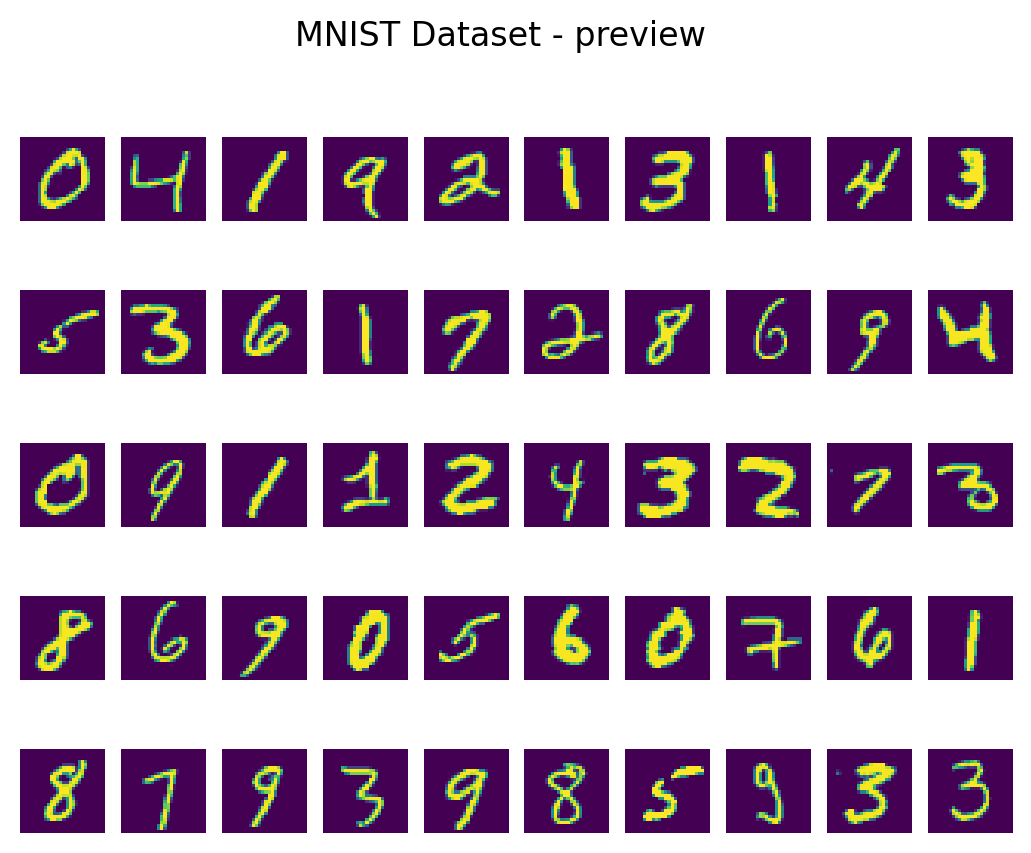

In [ ]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

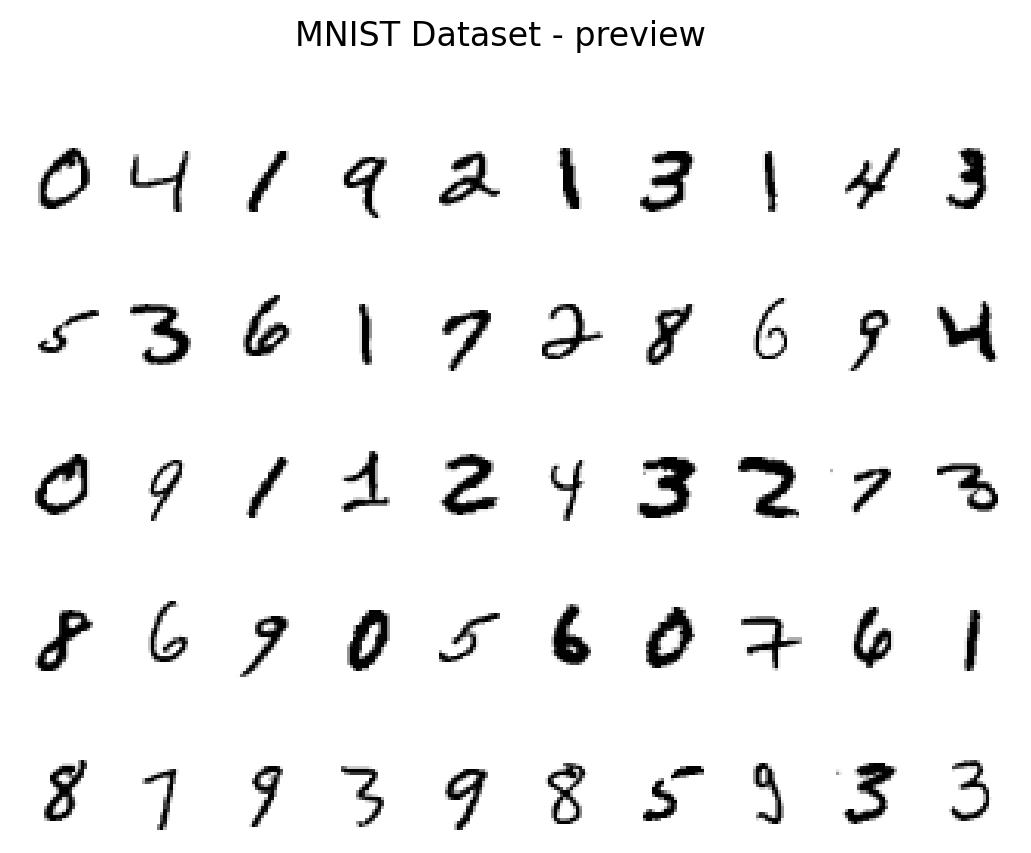

In [ ]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

# Implementação da rede

In [ ]:
trainCompTable = pd.DataFrame()
testCompTable = pd.DataFrame()
from google.colab import drive
drive.mount('/content/drive')
trainCompTable.to_csv('/content/drive/MyDrive/TG/train'+str(BATCH_IMAGE_INDEX)+'_'+str(SIZE_LOOP_TO_HOOK)+'.csv')
testCompTable.to_csv('/content/drive/MyDrive/TG/test'+str(BATCH_IMAGE_INDEX)+'_'+str(SIZE_LOOP_TO_HOOK)+'.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        # self.feature_extractor = nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        #     nn.Tanh(),
        #     nn.AvgPool2d(kernel_size=2),
        #     nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        #     nn.Tanh(),
        #     nn.AvgPool2d(kernel_size=2),
        #     nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        #     nn.Tanh()
        # )

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.tanh1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.tanh2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.tanh3 = nn.Tanh()

        # self.classifier = nn.Sequential(
        #     nn.Linear(in_features=120, out_features=84),
        #     nn.Tanh(),
        #     nn.Linear(in_features=84, out_features=n_classes),
        # )

        self.linr1 = nn.Linear(in_features=120, out_features=84)
        self.tanh4 = nn.Tanh()
        self.linr2 = nn.Linear(in_features=84, out_features=n_classes)


    def forward(self, x):

        x = self.conv1(x)
        x = self.tanh1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.tanh2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.tanh3(x)
        # x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.linr1(x)
        x = self.tanh4(x)
        x = self.linr2(x)

        # logits = self.classifier(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

00:29:16 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
00:29:49 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
00:30:18 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
00:30:48 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
00:31:17 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0415	Train accuracy: 99.25	Valid accuracy: 98.76
00:31:46 --- Epoch: 5	Train loss: 0.0298	Valid loss: 0.0453	Train accuracy: 99.40	Valid accuracy: 98.60
00:32:15 --- Epoch: 6	Train loss: 0.0251	Valid loss: 0.0439	Train accuracy: 99.50	Valid accuracy: 98.66
00:32:43 --- Epoch: 7	Train loss: 0.0222	Valid loss: 0.0443	Train accuracy: 99.39	Valid accuracy: 98.72
00:33:12 --- Epoch: 8	Train loss: 0.0195	Valid loss: 0.0421	Train accuracy: 99.57	Valid accuracy: 98.82
00:33:40 --- Epoch: 9	Train loss: 0.0171	Valid loss: 0.0458	Trai

<ipython-input-36-ceebf71dce09>:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


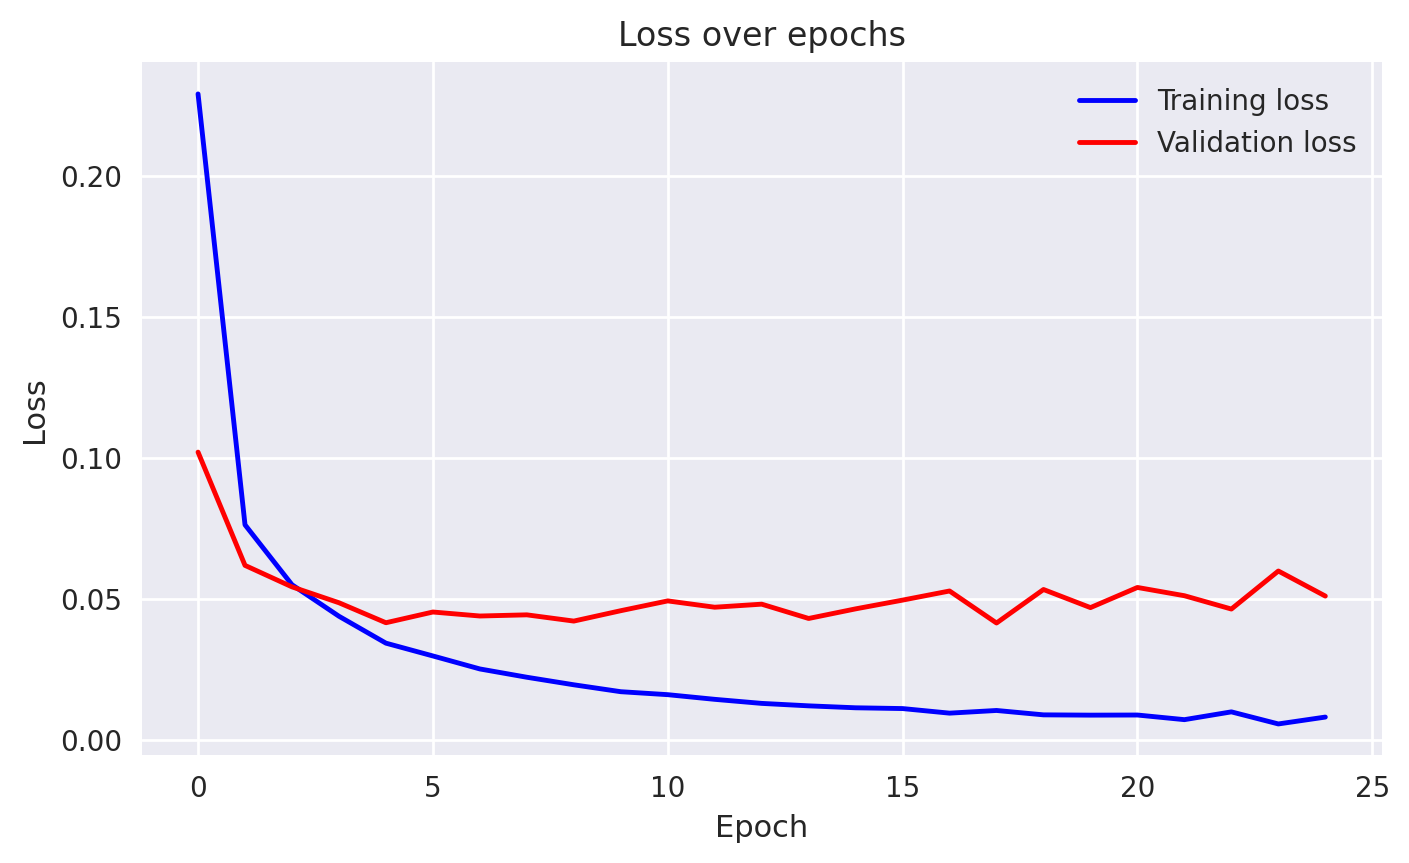

In [ ]:
model, optimizer, _, (trainCompTable, testCompTable), (train_accuracy, valid_accuracy) = training_loop_with_hooks(model,
                                                                                criterion,
                                                                                optimizer,
                                                                                train_loader,
                                                                                valid_loader,
                                                                                N_EPOCHS,
                                                                                DEVICE,
                                                                                hook_every=SIZE_LOOP_TO_HOOK,
                                                                                hook_layers=False)

In [ ]:
train_accuracy.to_csv('/content/drive/MyDrive/TG/train_accuracy'+'_'+str(SIZE_LOOP_TO_HOOK)+"_"+str(N_EPOCHS)+'.csv')
valid_accuracy.to_csv('/content/drive/MyDrive/TG/test_accuracy'+'_'+str(SIZE_LOOP_TO_HOOK)+"_"+str(N_EPOCHS)+'.csv')

In [ ]:
trainCompTable.to_csv('/content/drive/MyDrive/TG/train'+str(BATCH_IMAGE_INDEX)+'_'+str(SIZE_LOOP_TO_HOOK)+'.csv')
testCompTable.to_csv('/content/drive/MyDrive/TG/test'+str(BATCH_IMAGE_INDEX)+'_'+str(SIZE_LOOP_TO_HOOK)+'.csv')

In [ ]:
trainCompTable

,epoch,layer,metric,value


<Axes: >

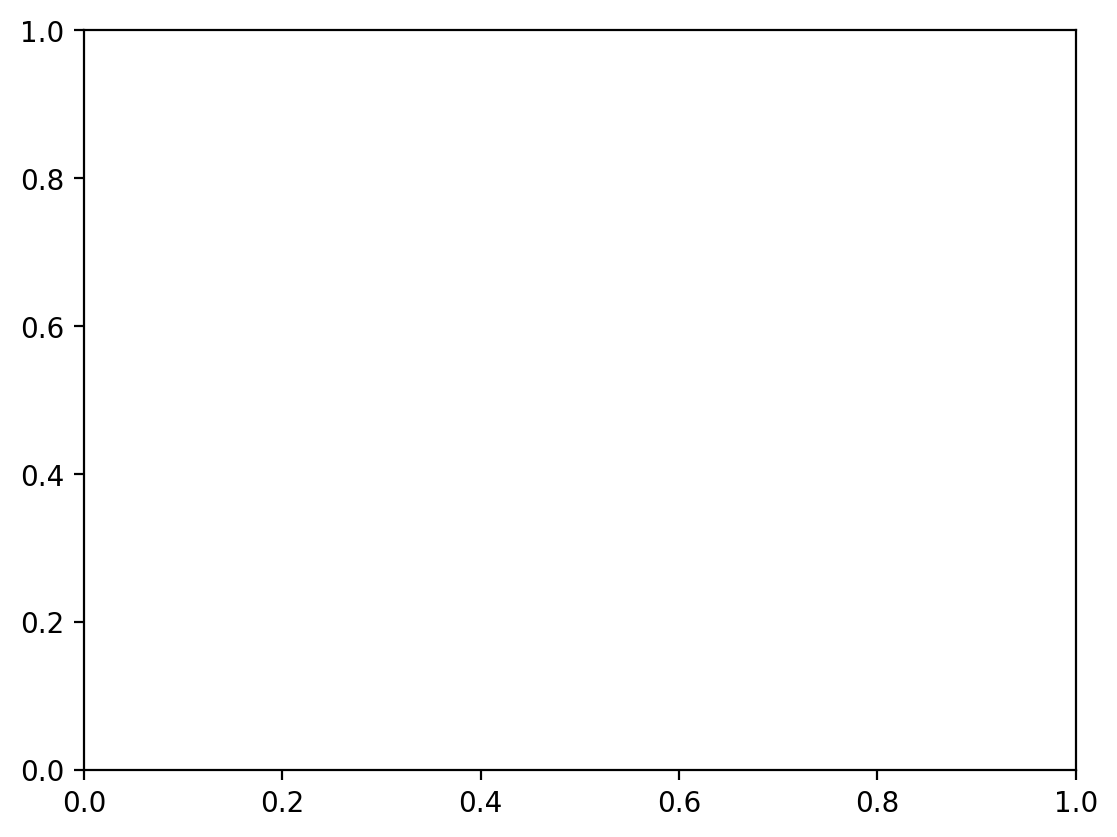

In [ ]:
import seaborn as sns

metricTable = trainCompTable[trainCompTable.metric == "n3"]
sns.lineplot(data=metricTable,x="layer",y="value",hue="epoch")

In [ ]:
trainCompTable

In [ ]:
import seaborn as sns

metricTable = trainCompTable[trainCompTable.metric == "n3"]
sns.lineplot(data=metricTable,x="layer",y="value",hue="epoch")

In [ ]:
d = {"a": 1, "b": 2}
pd.DataFrame.from_dict(d)

In [ ]:
display(trainIntermediateRepresentationComplexityTable)

In [ ]:

ty = torch.Tensor()
tx = torch.Tensor()
txs = []
tys = []
for X, y_true in train_loader:
    # ty = torch.cat((ty,y_true),0)
    # tx = torch.cat((tx,X),0)
    txs.append(X)
    tys.append(y_true)
rx = np.concatenate(txs)
ry = np.concatenate(tys)

In [ ]:
rx.shape

In [ ]:
# complexity_calculator_layer(tx,ty)
# rx.shape
rrx = rx.reshape(rx.shape[0],-1)
# rry = ry.reshape(ry.shape[0],-1)}
rry = ry.reshape(-1)
print(rrx.shape)
print(rry.shape)

mfc = MFEComplexity()
mfc.ft_n3(rrx,rry)

In [ ]:
torch.Tensor([[[[1]],[[2]]],[[[2]],[[3]]],[[[3]],[[4]]]]).flatten()

In [ ]:
tensor_debug
# nparray_debug

In [ ]:
trainIntermediateRepresentationComplexityTable

In [ ]:
for idx, layer in enumerate(model.named_children()):
  print("Idx: {} in {}".format(idx, str(layer[1])))

In [ ]:
for idx, (layerName, layer) in enumerate(model.named_children()):
  print(layerName)

## Avaliação das predições

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')

    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].to(DEVICE).unsqueeze(0))

    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [ ]:
# remove the downloaded dataset
!rm -r mnist_data

# Intermediate representations

In [ ]:
intermediateRepresentations = {}
with torch.no_grad():
  model.eval()
  for X, y in train_loader:
    # forward pass -- getting the outputs
    X = X.to(DEVICE)
    out = model(X)
    # collect the activations in the correct list
    for idx, (layerName, layer) in enumerate(model.named_children()):
      if layerName in intermediateRepresentations:
        intermediateRepresentations[layerName].append(activation[layerName])
      else:
        intermediateRepresentations[layerName] = [activation[layerName]]

In [ ]:
# intermediateRepresentations

In [ ]:
intermediateRepresentationsMapTensor = {}
with torch.no_grad():
  model.eval()
  for X, y in train_loader:
    # forward pass -- getting the outputs
    X = X.to(DEVICE)
    out = model(X)
    # collect the activations in the correct list
    for idx, (layerName, layer) in enumerate(model.named_children()):
      if layerName in intermediateRepresentationsMapTensor:
        t = intermediateRepresentationsMapTensor[layerName]
        t = torch.cat((t,activation[layerName]),0)
        intermediateRepresentationsMapTensor[layerName] = t
      else:
        intermediateRepresentationsMapTensor[layerName] = activation[layerName]

In [ ]:
for layerName, tensor in intermediateRepresentationsMapTensor.items():
  print("Layer Name: {}, and tensor size {}".format(layerName, tensor.size()))

Layer Name: feature_extractor, and tensor size torch.Size([60000, 120, 1, 1])
Layer Name: classifier, and tensor size torch.Size([60000, 10])


# Rascunho

In [ ]:
t1 = intermediateRepresentations['feature_extractor'][0]
t2 = intermediateRepresentations['feature_extractor'][1]
t3 = torch.cat((t1,t2),0)
t3.size()

torch.Size([64, 120, 1, 1])

In [ ]:
feat_map = {}
def hook_func(m,inp,op):
  feat_map['feat'] = op.detach()

In [ ]:
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
h1 = model.feature_extractor.register_forward_hook(getActivation("feature_extractor"))
h2 = model.classifier.register_forward_hook(getActivation("classifier"))

In [ ]:
i = 0
for idx, (X, y) in enumerate(train_dataset):
  # if (idx == 1):
  #   first_batch = X
  #   break
  i = i+1
# first_batch
i

60000

In [ ]:
BATCH_SIZE

32

In [ ]:
get_accuracy(model,train_loader,DEVICE)

tensor(0.9978, device='cuda:0')

In [ ]:
classifier_list, feature_extractor_list = [],[]
with torch.no_grad():
  model.eval()
  for X, y in train_loader:
    # forward pass -- getting the outputs
    X = X.to(DEVICE)
    out = model(X)
    # collect the activations in the correct list
    feature_extractor_list.append(activation['feature_extractor'])
    classifier_list.append(activation['classifier'])

In [ ]:
# detach the hooks
h1.remove()
h2.remove()


In [ ]:
classifier_list[0]

tensor([[ -3.7201,  -2.9144,  -0.5515,  17.9743,  -5.3545,  -0.3219,  -7.1712,
          -4.0967,  -0.2157,   0.2398],
        [  2.1187,  -4.6192,  -8.7556,   7.5722,  -8.5671,  14.4749,  -1.2608,
          -5.7316,   0.3225,   0.6799],
        [ -5.8856,  -6.8021, -10.0577,   3.5322,  -4.4600,  18.3038,  -1.5895,
          -2.8938,   0.1368,   4.0350],
        [  1.0720,  -4.9815,   0.2119,  -3.8567,  -8.8140,   4.6960,   2.9239,
          -4.6730,  13.5678,  -2.6466],
        [ -4.7579,  -1.3490,   1.0450,  14.1711,  -2.8410,  -1.8328,  -9.7761,
          -1.5574,  -1.5881,   3.0418],
        [ -1.9867,  -2.3967,  -2.1828,  -1.2643,   2.0076,   5.6341,  16.8223,
          -7.3133,   0.6360,  -5.8666],
        [ -6.2722,   0.8967,   6.2101,   2.9019,   1.3191,  -7.8101, -13.7437,
          16.7140,  -3.7574,   1.2465],
        [  0.6728,   3.9819,  11.5149,  -4.0674,  -0.5248, -12.7066,   0.0299,
           1.2659,   1.0998,  -0.3317],
        [ -9.8170,  15.4744,  -1.8467,  -2.9182,

In [ ]:
model

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
# get_accuracy(model, train_loader, DEVICE)

In [ ]:
model

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
print(type(model))
for children in model.children():
  print(type(children))

<class '__main__.LeNet5'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.container.Sequential'>


In [ ]:
a = np.arange(4)
b = a.copy()
a[0] = 1
a[3] = 0
print(a.shape)
print(b.shape)
a.T

(4,)
(4,)


array([1, 1, 2, 0])

In [ ]:
test = np.array(
      [np.equal(a, C) for C in b], dtype=bool
)
test

array([[False, False, False,  True],
       [ True,  True, False, False],
       [False, False,  True, False],
       [False, False, False, False]])

In [ ]:
np.equal(a,b)

array([False,  True,  True, False])

# Execute layer to layer

In [ ]:
np.equal(a,b)